In [0]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn import svm, metrics
import math
import IPython.display as ipd
import scipy as sp
import seaborn as sn

##Importing and fitting the data

In [24]:
! git clone 'https://github.com/Jakobovski/free-spoken-digit-dataset.git'

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


In [0]:
# dataframe that shows digit, name of speaker and role (train/test) for every namefile

root = 'free-spoken-digit-dataset/recordings/'

files = pd.Series([f for f in os.listdir(root)])

data = pd.DataFrame(columns=['names', 'digit', 'role'], index=files)

# populating the dataframe 

for f in files:
  nam = f.split('_')
  nam = nam[1]  # name of the speaker

  num = int(f[0])  # spoken digit

  cod = f[-6:-4]
  if cod[0] == '_':
    cod = cod[1]
  
  if int(cod) >= 5:
    role = 'train'
  else:
    role = 'test'


  data.at[f, 'names'] = nam
  data.at[f, 'digit'] = num
  data.at[f, 'role'] = role

In [26]:
# examples of use
data[data['role'] == 'train'].index # all files of the training set
data[data['names'] == 'theo'].index # all files with speaker theo
data[data['digit'] == 4].index.size # number of files where spoken digit is 4

200

#Parameters

In [0]:
n_fft = 2048;

# max length of our files, in samples. In practice, this parameter is used only to truncate some files that contain noise at the end
max_length_wanted = 8000 #or length_wanted = max_length (from statistics above)

fs = 8000;

#Approximate window length that we want (related to our sampling frequency!)
#8000/512 represents the ratio we want to have, according to some speech processing rules (can also be 22050/1024 - thats even more windows)
win_length_approx = 1200;

#number of windows and number of frames considering the hop size
n_windows = math.ceil(max_length_wanted / win_length_approx)
hop_ratio = 2;
n_frames = n_windows*hop_ratio + 1;

n_mfcc = 13
n_mfcc_flat = n_mfcc*n_frames

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#Preprocesing


## Files truncation

Truncating the files that are longer than the wanted length

In [0]:
def truncate():

  for c in classes:
    
    #Picking the samples that correspond to the chosen class
    gen = data[data['digit'] == int(c)].index       
    for index, f in enumerate(gen):    

      audio, fs = librosa.load(os.path.join(root, f), sr=None)
      
      # Truncating the files whose length is above max_length_wanted
      if len(audio)>max_length_wanted:
        audio = audio[0 : max_length_wanted]
        librosa.output.write_wav(os.path.join(root, f), audio, fs) #Overwriting the file (after truncating)

In [0]:
truncate();

## Adaptive window length

* We have files with different length, yet we want the same number of frames in the end, with the same n_fft

* The number of wanted frames defined by the parameters above






In [0]:
# Computing the dynamic window length according to the length of the given audio file
def window_length(audio_length):
   
   # Number of windows (not frames) we want to have in our audio
   n_windows = math.ceil(max_length_wanted / win_length_approx) 

   return math.floor(audio_length / n_windows)

#Features extraction

## Computation of MFCCs

In [0]:
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    
    win_length = window_length(len(audio));
    hop_length = int(win_length/hop_ratio);

    X = np.abs(librosa.stft(
        audio,
        win_length=win_length,
        window='hamming',
        n_fft=n_fft,
        hop_length=hop_length,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=n_fft,
        n_mels=40,
        fmin=133.33,
        fmax=int(fs/2)
    )
    
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    return mfcc

## Extracting MFCCs from the training set

In [0]:
dict_train_features = {}

for c in classes:

  gen = data[(data['role'] == 'train') & (data['digit'] == int(c))].index 
  n_train_samples = len(gen)

  train_features = np.zeros((n_train_samples, n_mfcc_flat))
  
  for index, f in enumerate(gen):    
    audio, fs = librosa.load(os.path.join(root, f), sr=None)
    mfcc = compute_mfcc(audio, fs, n_mfcc)
    train_features[index, :] = mfcc.flatten()

  dict_train_features[c] = train_features


##Extracting MFCCs from the testing set

In [0]:
dict_test_features = {}

for c in classes:

  gen = data[(data['role'] == 'test') & (data['digit'] == int(c))].index
  n_test_samples = len(gen)

  test_features = np.zeros((n_test_samples, n_mfcc_flat))
  
  for index, f in enumerate(gen):    

    audio, fs = librosa.load(os.path.join(root, f), sr=None)
    mfcc = compute_mfcc(audio, fs, n_mfcc)
    test_features[index, :] = mfcc.flatten()

   
  dict_test_features[c] = test_features


##Visualization of MFCCs

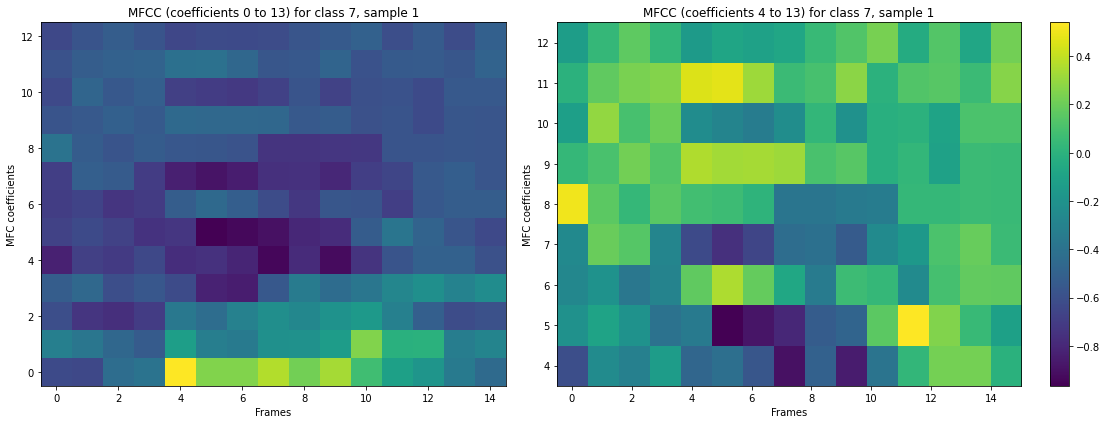

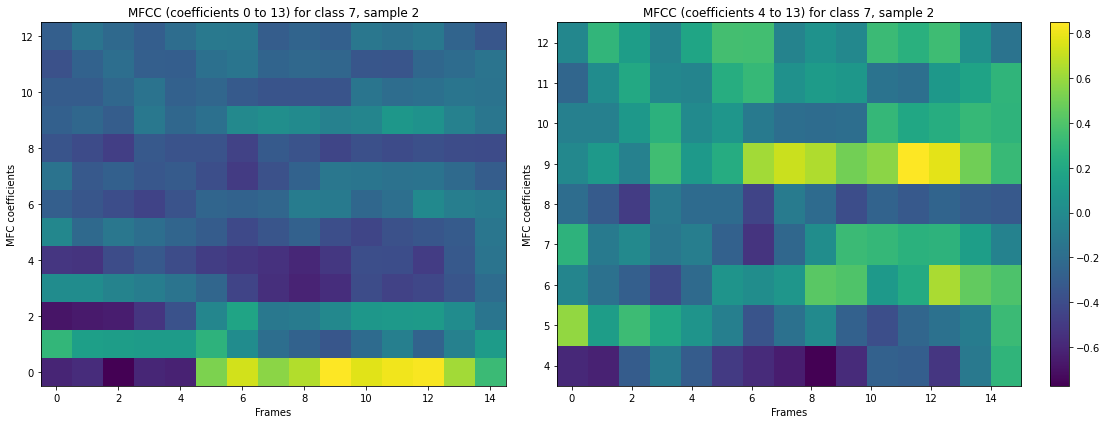

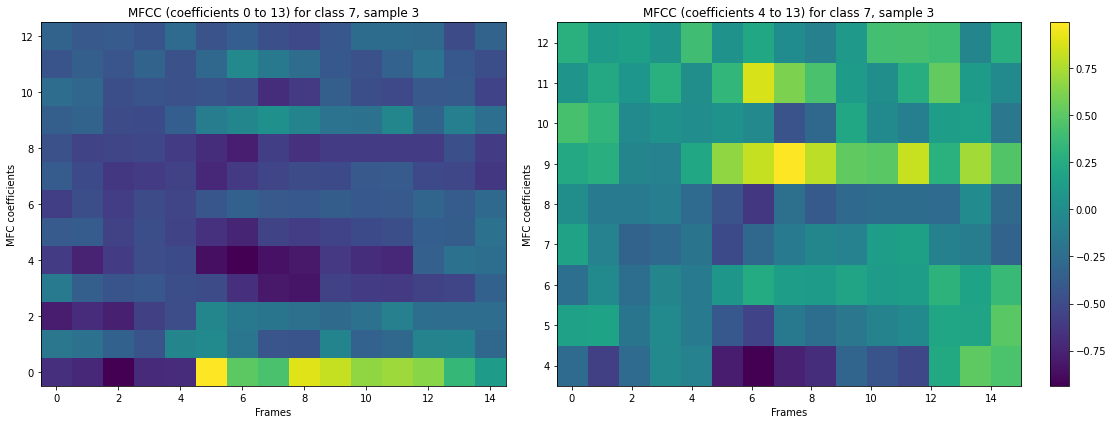

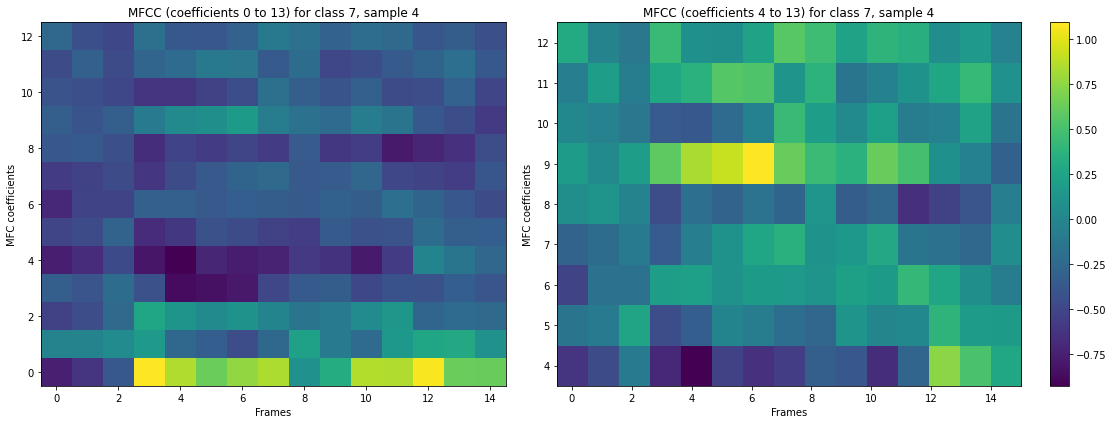

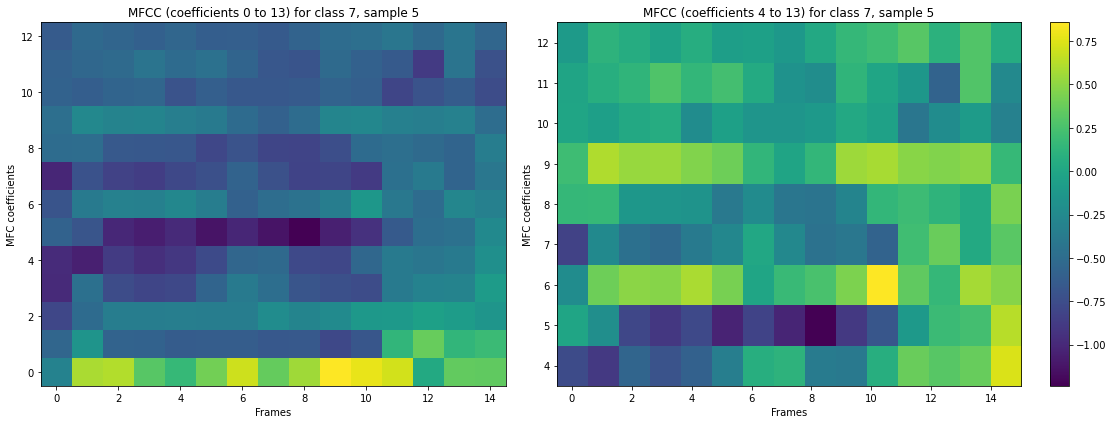

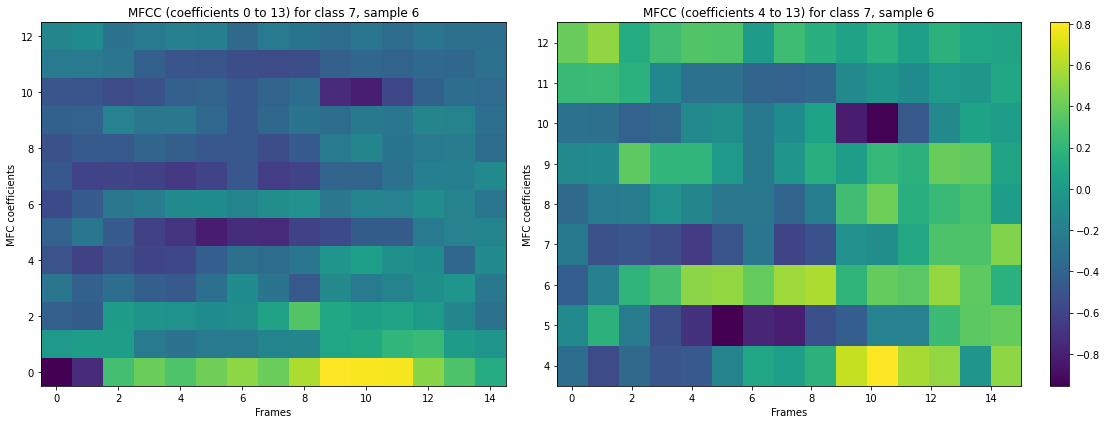

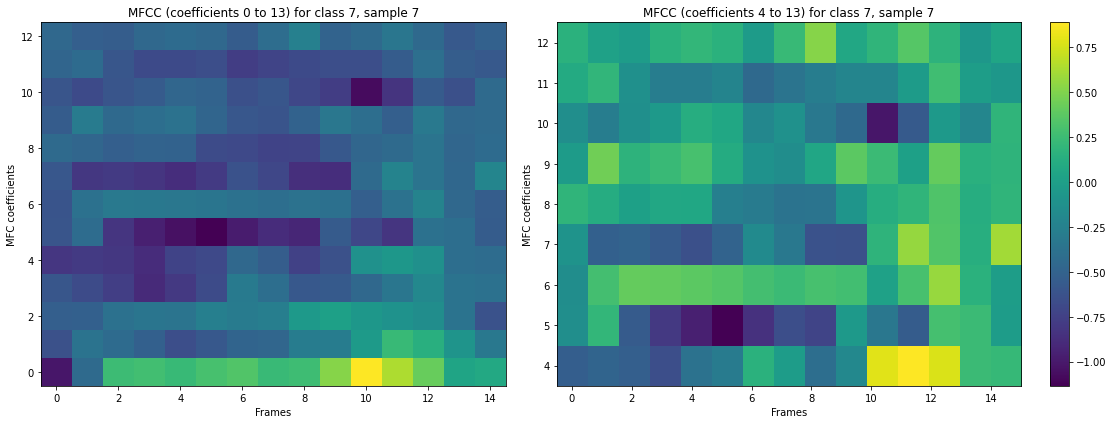

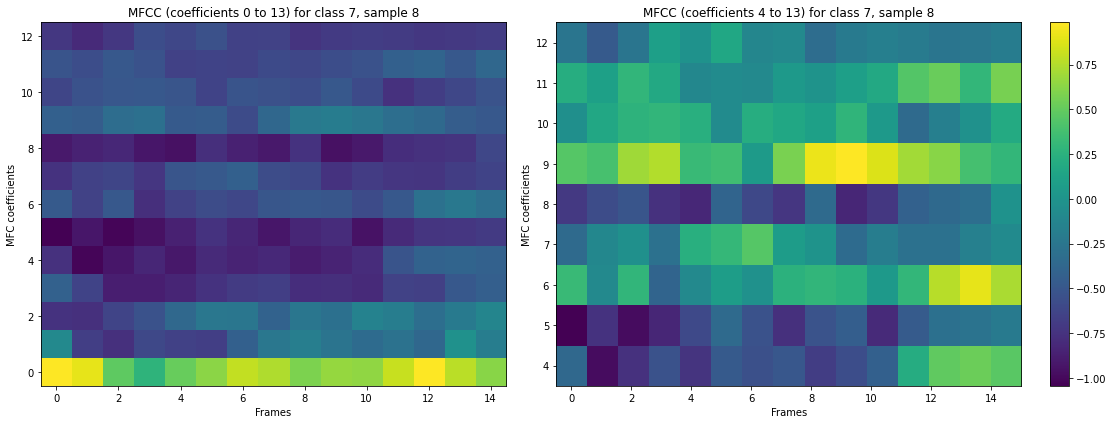

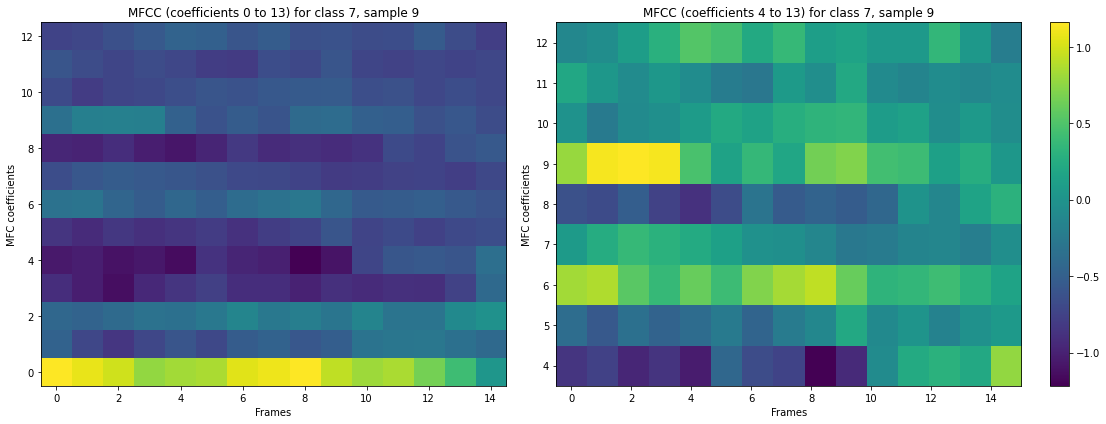

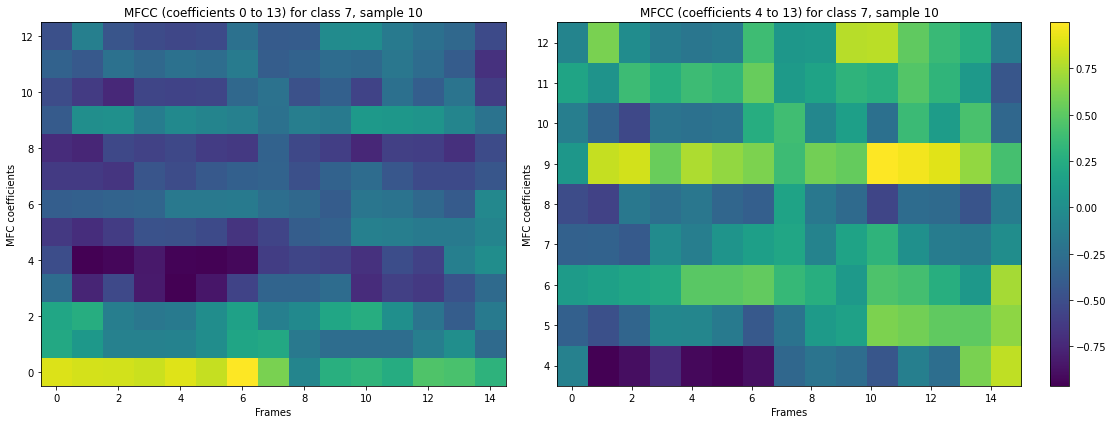

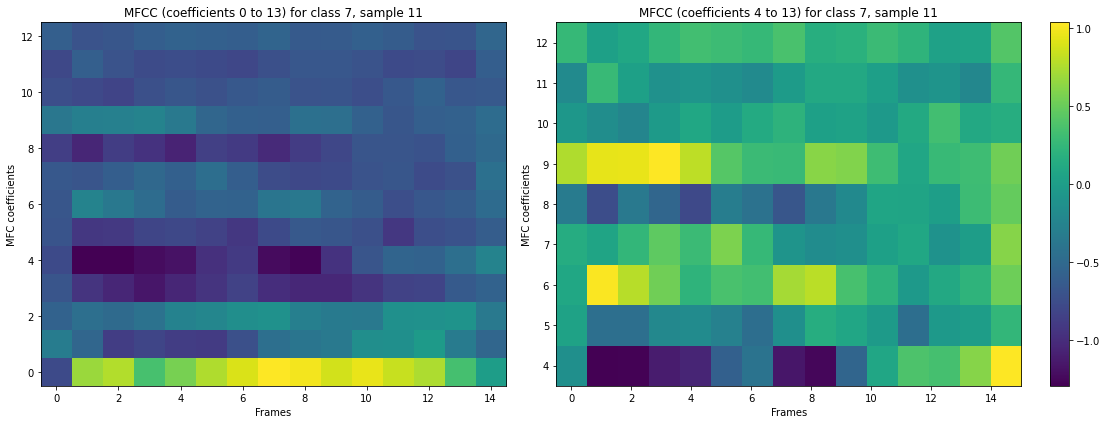

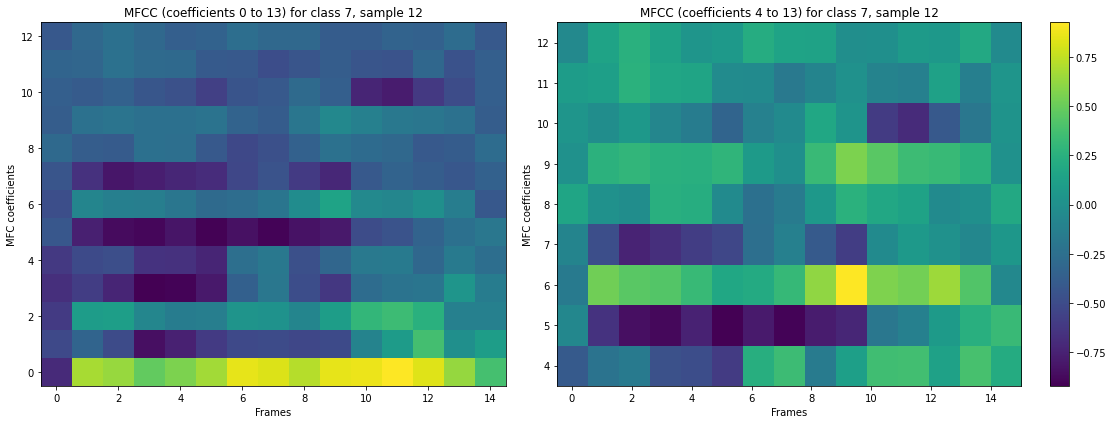

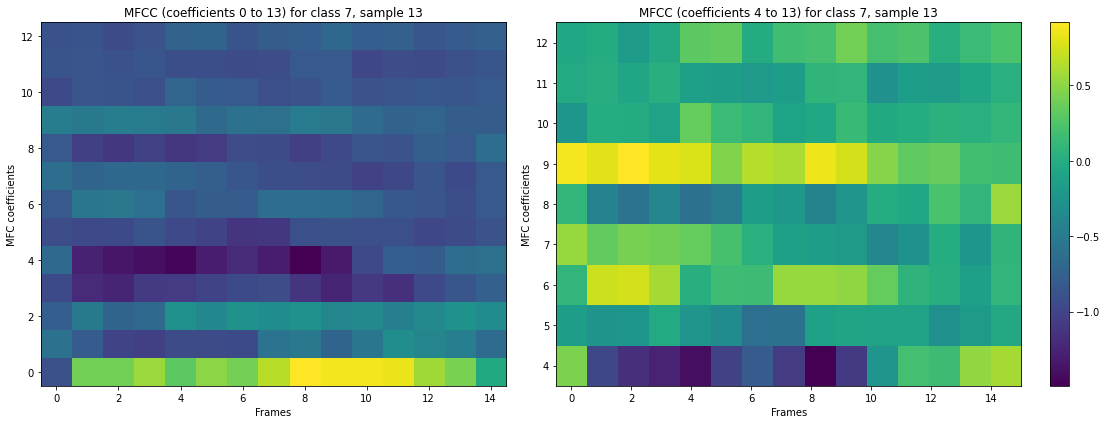

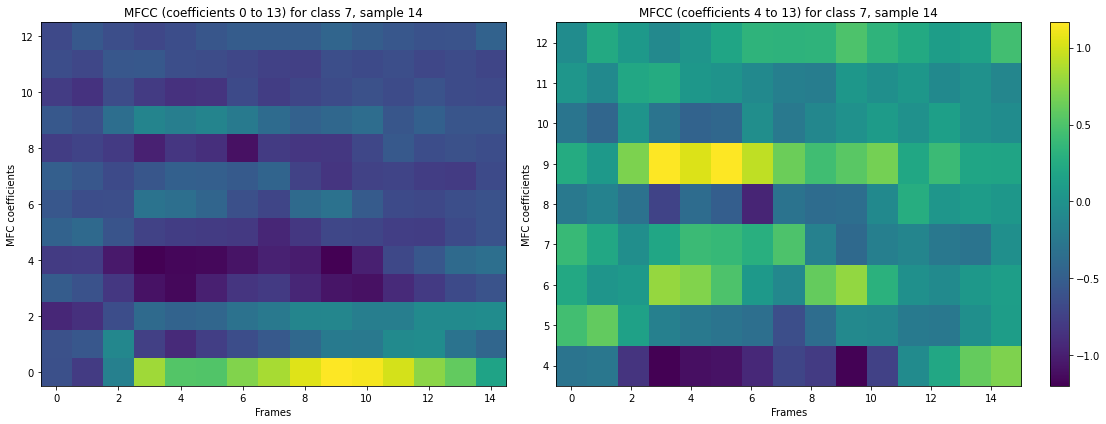

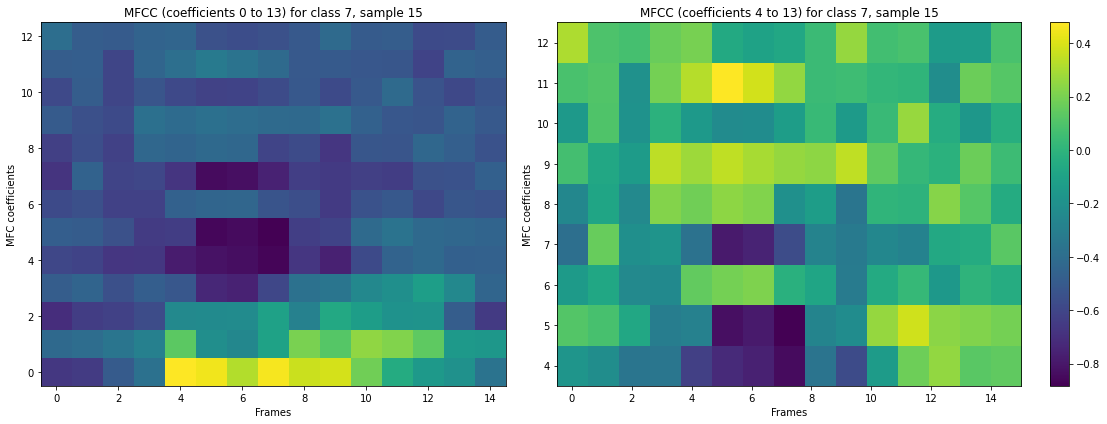

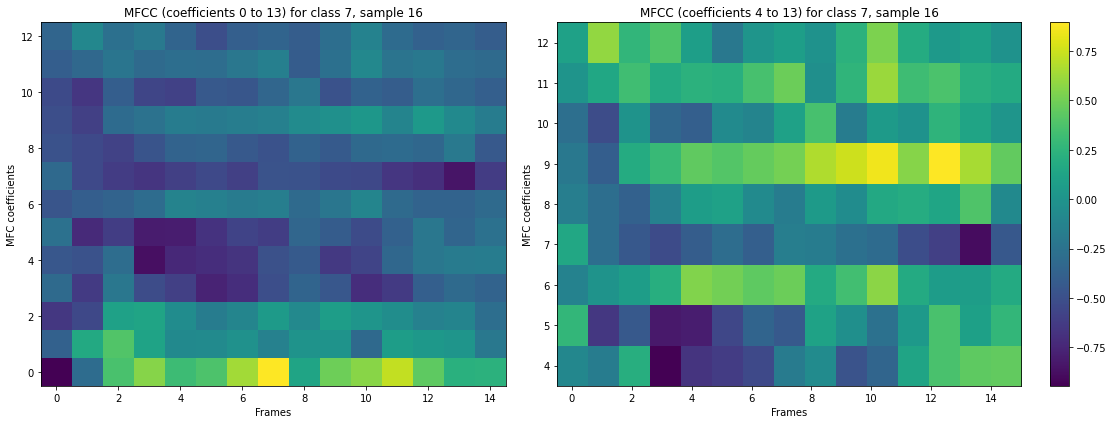

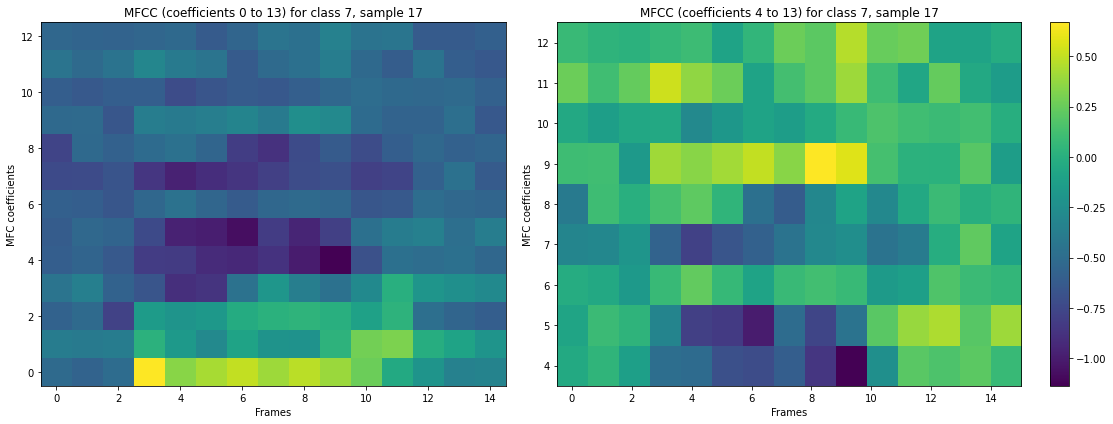

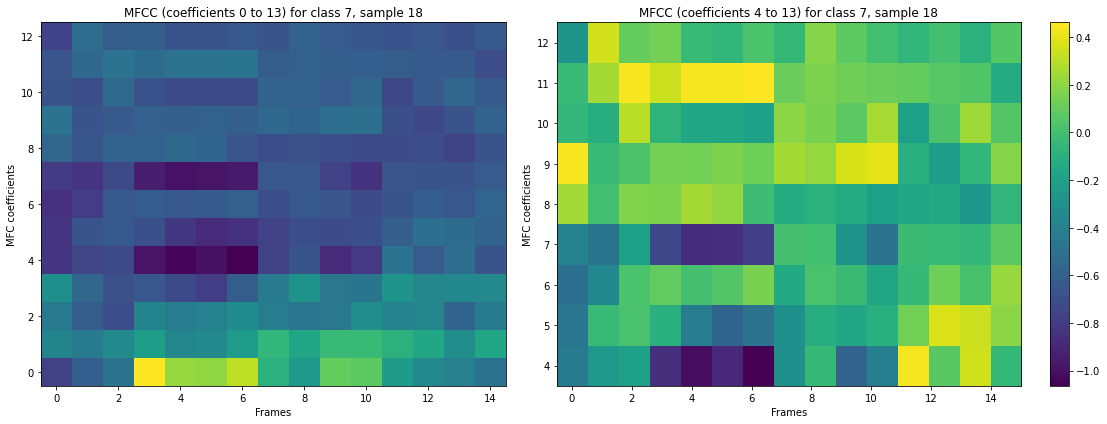

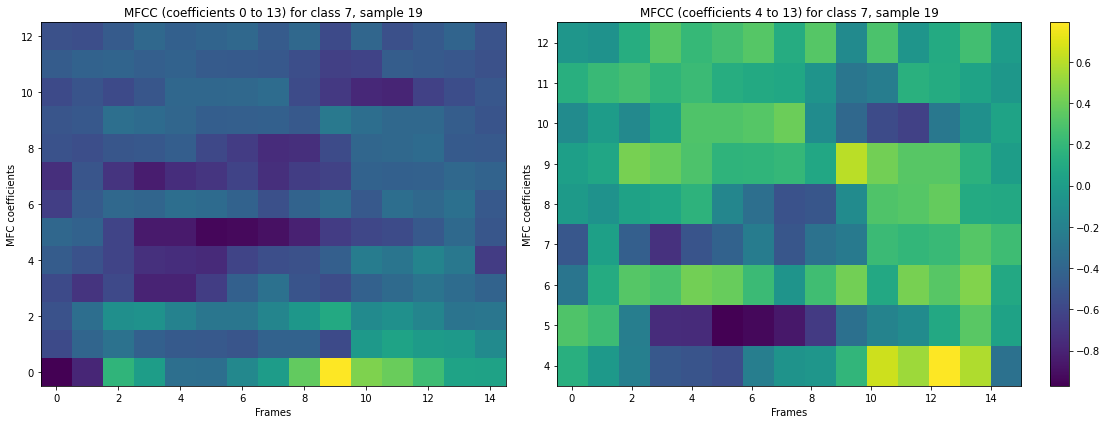

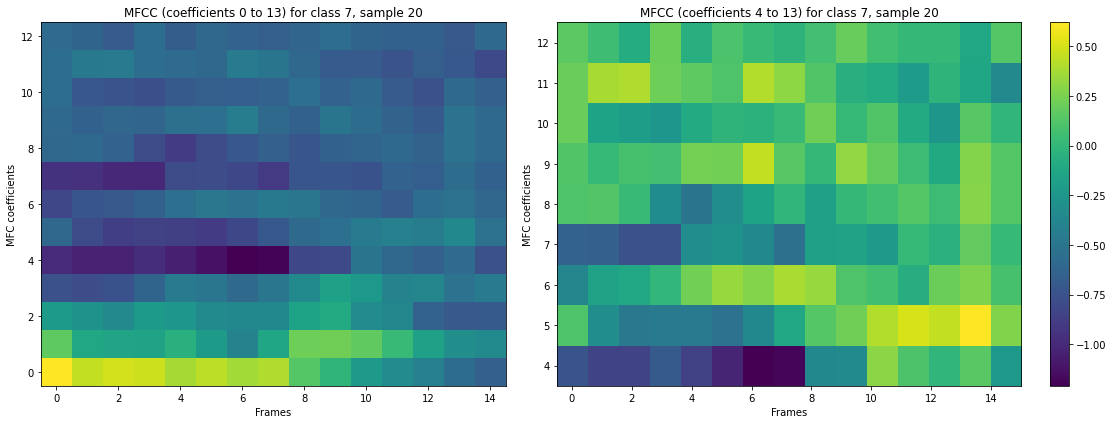

In [34]:
#Example of MFCCs through time, for the example of testing samples in the class c = 7

c = "7"
mfcc = dict_test_features[c].transpose()
for index, f in enumerate(dict_test_features[c]):
  reshaped_mfcc = np.reshape(f, (-1, n_frames))

  # Visualization
  fig = plt.figure(figsize=(16, 6))
  plt.subplot(1,2,1)
  plt.imshow(reshaped_mfcc, origin='lower', aspect='auto')
  plt.xlabel('Frames')
  plt.ylabel('MFC coefficients')
  plt.title('MFCC (coefficients 0 to 13) for class {}, sample {}'.format(c, index + 1))
  plt.colorbar()
  plt.tight_layout()

  mfcc_upper = reshaped_mfcc[4:]
  plt.subplot(1,2,2)
  plt.imshow(mfcc_upper, origin='lower', aspect='auto', extent=[-0.5, n_frames, 3.5, 12.5])
  plt.title('MFCC (coefficients 4 to 13) for class {}, sample {}'.format(c, index + 1))
  plt.xlabel('Frames')
  plt.ylabel('MFC coefficients')
  plt.colorbar()
  plt.tight_layout()

#SVM Classification

In [0]:
# Training set

dict_X_train = dict_train_features  # X : input  (i.e the features' value)
dict_Y_train = {}                   # Y : output (i.e the class)
x_train_mc = []

for i in range(len(classes)):
  # i being the int value of the class(1,2,3,..), the output can be a list full of i.
  dict_Y_train[classes[i]] = np.ones((dict_train_features[classes[i]].shape[0],))*i
  
  if i==0: #initiating the concatenation
    x_train_mc = dict_X_train[classes[i]]
  else:
    x_train_mc = np.concatenate((x_train_mc, dict_X_train[classes[i]]), axis=0)


# Testing set 

dict_X_test = dict_test_features
dict_Y_test = {}
y_test_mc = []

for i in range(len(classes)):
  dict_Y_test[classes[i]] = np.ones((dict_test_features[classes[i]].shape[0],))*i
  y_test_mc = np.concatenate((y_test_mc, dict_Y_test[classes[i]]), axis=0)


In [0]:
# Normalising :

dict_X_train_normalised= {}
dict_X_test_normalised= {}
X_test_mc_normalized = []

feat_max = np.max(x_train_mc, axis=0)
feat_min = np.min(x_train_mc, axis=0)


for i in range(len(classes)):
  dict_X_train_normalised[classes[i]] = (dict_X_train[classes[i]] - feat_min) / (feat_max - feat_min)
  dict_X_test_normalised[classes[i]] = (dict_X_test[classes[i]] - feat_min) / (feat_max - feat_min)
  if i==0: #initiating the concatenation
    X_test_mc_normalized = dict_X_test_normalised[classes[i]]
  else:
    X_test_mc_normalized = np.concatenate((X_test_mc_normalized, dict_X_test_normalised[classes[i]]), axis=0)



In [0]:
# defining and training the model for each couple of classes :

SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

dict_classifiers = {}

#creating and fitting all the binary svm classifiers (all possible pairs of class i and j)
for i in range(len(classes)):
  for j in range(i+1,len(classes)):
    clf_name = "clf_"+str(i)+str(j)
    dict_classifiers[clf_name] = sklearn.svm.SVC(**SVM_parameters, probability=True)
    dict_classifiers[clf_name].fit(np.concatenate((dict_X_train_normalised[classes[i]], dict_X_train_normalised[classes[j]]), 
           axis=0), np.concatenate((dict_Y_train[classes[i]], dict_Y_train[classes[j]]), axis=0))


In [0]:
# Evaluating each classifier :

dict_y_test_predicted = {}
y_test_predicted_mc = []

for i in range(len(classes)):
  for j in range(i+1,len(classes)):
    clf_name = "clf_"+str(i)+str(j)
    y_test_str = "y_test_predicted_"+str(i)+str(j)
    dict_y_test_predicted[y_test_str] = dict_classifiers[clf_name].predict(X_test_mc_normalized).reshape(-1, 1)

    if (i==0 and j==1):
      y_test_predicted_mc = dict_y_test_predicted[y_test_str]
    else:
      y_test_predicted_mc = np.concatenate((y_test_predicted_mc, dict_y_test_predicted[y_test_str]), axis=1)


y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)

#Majority voting :

y_test_predicted_mv = np.zeros((y_test_predicted_mc.shape[0],))
for i, e in enumerate(y_test_predicted_mc):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

#Confusion matrix

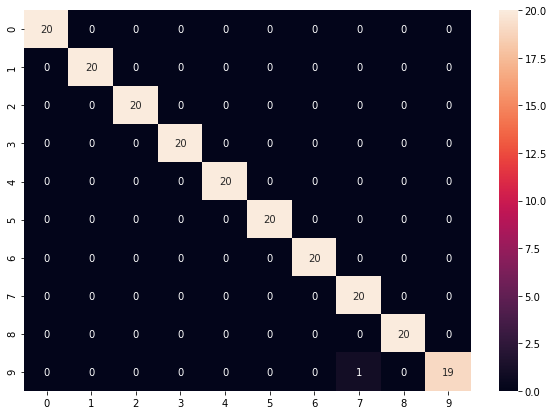

In [39]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_mc, y_test_predicted_mv)

df_cm = pd.DataFrame(confusion_matrix, index = np.arange(10), columns =np.arange(10))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)



#BONUS: Exploring the data

## Statistics
* Checking the duration of files: max length is 7038 samples and there are other 4 noisy files

In [0]:
dict_classes = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': []}

for c in dict_classes.keys():

  max_min = []
  gen = data[data['digit'] == int(c)].index #picking the samples that correspond to the chosen class
    
  length_wanted = 8000
  
  for index, f in enumerate(gen):    

    audio, fs = librosa.load(os.path.join(root, f), sr=None)
    
    duration = len(audio)
    dict_classes[c].append(duration)
    if duration<length_wanted:
      max_min.append(len(audio)) # use this one if we want to have stats discarding the "exceptions"

    if duration>length_wanted:
      print("Exception: ", len(audio))

    #max_min.append(len(audio)) - use this one if we also want the exceptions in the stats

  print("class {}: ".format(c), "duration between {} and {} samples".format(min(max_min),max(max_min)))
  max_length = max(max_min);


class 0:  duration between 2261 and 6273 samples
class 1:  duration between 1556 and 6112 samples
class 2:  duration between 1288 and 5909 samples
class 3:  duration between 1455 and 4920 samples
class 4:  duration between 1359 and 5467 samples
Exception:  8201
class 5:  duration between 1673 and 5470 samples
class 6:  duration between 1148 and 7038 samples
Exception:  17567
class 7:  duration between 1965 and 6265 samples
class 8:  duration between 1749 and 5077 samples
Exception:  8281
Exception:  18262
class 9:  duration between 1778 and 6953 samples


In [0]:
ipd.Audio(dict_classes["9"][1], rate=dict_classes["fs"]) # load a local WAV file

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9')]

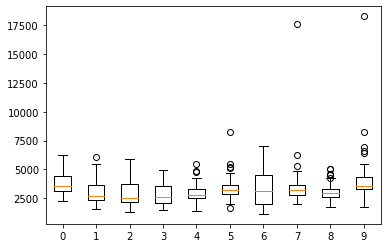

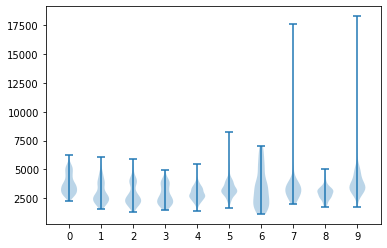

In [0]:
fig, ax = plt.subplots()
ax.boxplot(dict_classes.values())
ax.set_xticklabels(dict_classes.keys())

fig2, ax2 = plt.subplots()
ax2.violinplot(dict_classes.values())
ax2.set_xticks(np.arange(1, len(dict_classes) + 1))
ax2.set_xticklabels(dict_classes.keys())

##Spectrograms representation



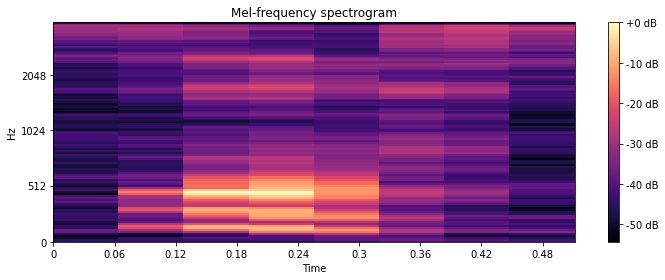

In [0]:
#Mel - frequency spectrogram

audio_file = 'free-spoken-digit-dataset/recordings/6_theo_8.wav'
y, sr = librosa.load(os.path.join(audio_file), sr=8000)
S = librosa.feature.melspectrogram(y=y, sr=sr);
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=4000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


3853


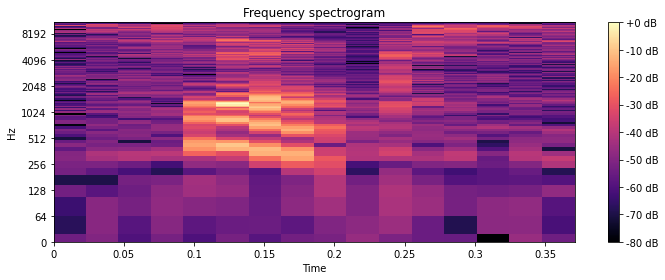

In [0]:
#Frequency spectrogram

audio_file = 'free-spoken-digit-dataset/recordings/6_theo_8.wav'
y, sr = librosa.load(os.path.join(audio_file), sr=None)
print(len(y))

S1 = np.abs(librosa.stft(y=y, n_fft=512,
        hop_length=256,))

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(S1,ref=np.max),y_axis='log', x_axis='time')
#S_dB = librosa.power_to_db(S1, ref=np.max)
#librosa.display.specshow(S_dB, x_axis='time', y_axis='hz', sr=sr, fmax=4000)

plt.colorbar(format='%+2.0f dB')
plt.title('Frequency spectrogram')
plt.tight_layout()
plt.show()

## Plotting audio files in time domain

Text(0.5, 1.0, 'Class 9, audio sample 1')

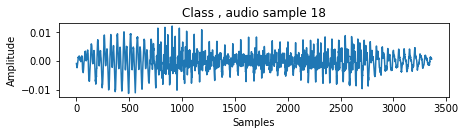

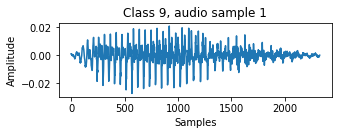

In [45]:
fig = plt.figure(figsize = (10*0.7,3))

f = '9_theo_18.wav'
audio, fs = librosa.load(os.path.join(root, f), sr=None);
plt.subplot(2,1,1)
plt.plot(audio)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Class , audio sample 18')

fig1 = plt.figure(figsize = (7*0.7,3))
f = '9_theo_1.wav'
audio, fs = librosa.load(os.path.join(root, f), sr=None);
plt.subplot(2,1,2)
plt.plot(audio)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Class 9, audio sample 1')
  